MC920 / MO443 (Introdução ao Processamento Digital de Imagem)

Prof. Hélio Pedrini

Matheus Xavier Sampaio - RA 220092

# Instruções

## Arquivos

O arquivo `Trabalho_04.ipynb` possui um notebook executável com os códigos e o relatório do trabalho.

O arquivo `Trabalho_04.pdf` possui o notebook em formato `pdf` com o relatório do trabalho.

Os arquivos `Trabalho_04_transformacoes.py` e `Trabalho_04_panoramica.py` possuem scripts com os códigos do trabalho.

## Ambiente e Execução

O arquivo `environment.yml` pode ser utilizado para criar um ambiente `conda` com todas as dependencias para executar o trabalho.

Caso tenha o Anaconda instalado, basta executar o comando: `$ conda env create`

Apos instalar o ambiente, ative usando o comando: `$ conda activate mo443`

Este trabalho utiliza um algoritmo de detectores de pontos de interesse e descritores que que possui uma patente ainda em vigor, assim, é necessário modificar a instalação do `opencv` para permitir seu uso. Isto é feito da seguinte forma:
- Com o ambiente ativado, crie as seguintes variáveis de ambiente: `$ export CMAKE_ARGS="-DOPENCV_ENABLE_NONFREE=ON" CMAKE_GENERATOR="Ninja"`
- Instale novamente o opencv, desta vez realizando a build para permitir o uso de métodos 'non free': `$ pip install --no-binary opencv-contrib-python opencv-contrib-python`
- Como estaremos contruindo o `wheel` do opencv, esta operação pode demorar alguns minutos, mas é necessária para a execução de todos os detectores pedidos

Por fim, execute o script python para criar as imagens com a visualização de cada questão: `$ python Trabalho_04_{transformacoes|panoramica}.py`. Para ver as opções possíveis para a execução do script, execute `$ python Trabalho_04_{transformacoes|panoramica}.py -h`.

Se preferir, abra o notebook e execute uma célula por vez.

In [1]:
import cv2
import requests
import matplotlib.pyplot as plt
import numpy as np

from urllib.parse import urlparse
from pathlib import Path

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [3]:
def image_from_url_or_disk(path):
    if urlparse(path).scheme:
        resp = requests.get(path)
        image = np.asarray(bytearray(resp.content), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    elif Path(path).exists():
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        raise ValueError('caminho deve ser url ou arquivo')
    return image

In [4]:
def show_images(grid, images, titles, filepath=None, figsize=None):
    if figsize is None:
        figsize = (19, 10)
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles), start=1):
        plt.subplot(*grid, i)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    if filepath:
        plt.suptitle(filepath)
        plt.savefig(f'{filepath}.png', transparent=False)
    plt.show()

# Transformações Geométricas e Colagem de Imagens

In [5]:
url = 'https://images.sftcdn.net/images/t_app-logo-l,f_auto/p/08c754d6-a4d7-11e6-a2ba-00163ec9f5fa/2838535805/letter-chain-logo.png'
image = image_from_url_or_disk(url)

## Transformação Geométrica

### Redimensionar

In [6]:
def nearest_neighbor_interpolation(indices, image):
    indices = np.round(indices).astype(int)
    w, h = image.shape
    w, h = w - 1, h - 1

    scaled = image[np.clip(indices[0], 0, w), np.clip(indices[1], 0, h)]
    return scaled.astype(np.uint8)

In [7]:
def bilinear_interpolation(indices, image):
    dx, dy = indices - np.floor(indices)
    w, h = image.shape
    w, h = w - 1, h - 1

    x_l = np.floor(indices[0]).astype(int)
    y_l = np.floor(indices[1]).astype(int)

    f_x_y = image[np.clip(x_l, 0, w), np.clip(y_l, 0, h)]
    f_x1_y = image[np.clip(x_l + 1, 0, w), np.clip(y_l, 0, h)]
    f_x_y1 = image[np.clip(x_l, 0, w), np.clip(y_l + 1, 0, h)]
    f_x1_y1 = image[np.clip(x_l + 1, 0, w), np.clip(y_l + 1, 0, h)]

    scaled = (
        (1 - dx) * (1 - dy) * f_x_y
        + dx * (1 - dy) * f_x1_y
        + (1 - dx) * dy * f_x_y1
        + dx * dy * f_x1_y1
    )
    return scaled.astype(np.uint8)

In [8]:
def P(t):
    return np.maximum(t, 0)


def R(s):
    return 1/6 * (P(s + 2)**3 - 4*P(s + 1)**3 + 6*P(s)**3 - 4*P(s - 1)**3)


def bicubic_interpolation(indices, image):
    dx, dy = indices - np.floor(indices)
    w, h = image.shape
    w, h = w - 1, h - 1

    x_l = np.floor(indices[0]).astype(int)
    y_l = np.floor(indices[1]).astype(int)

    mn = [-1, 0, 1, 2]

    scaled = np.zeros_like(indices[0], dtype=float)
    for m in mn:
        for n in mn:
            f_x_y = image[np.clip(x_l + m, 0, w), np.clip(y_l + n, 0, h)]
            r_m = R(m - dx)
            r_n = R(dy - n)
            scaled += f_x_y * r_m * r_n
    return scaled.astype(np.uint8)

In [9]:
def L(n, dx, x, y, image):
    w, h = image.shape
    w, h = w - 1, h - 1

    return (
        (-dx * (dx - 1) * (dx - 2) * image[np.clip(x - 1, 0, w), np.clip(y + n - 2, 0, h)]) / 6
        + ((dx + 1) * (dx - 1) * (dx - 2) * image[np.clip(x, 0, w), np.clip(y + n - 2, 0, h)]) / 2
        + (-dx * (dx + 1) * (dx - 2) * image[np.clip(x + 1, 0, w), np.clip(y + n - 2, 0, h)]) / 2
        + (dx * (dx + 1) * (dx - 1) * image[np.clip(x + 2, 0, w), np.clip(y + n - 2, 0, h)]) / 6
    )


def lagrange_interpolation(indices, image):
    dx, dy = indices - np.floor(indices)
    w, h = image.shape
    w, h = w - 1, h - 1

    x_l = np.floor(indices[0]).astype(int)
    y_l = np.floor(indices[1]).astype(int)

    l_1 = L(1, dx, x_l, y_l, image)
    l_2 = L(2, dx, x_l, y_l, image)
    l_3 = L(3, dx, x_l, y_l, image)
    l_4 = L(4, dx, x_l, y_l, image)

    scaled = (
        (-dy * (dy - 1) * (dy - 2) * l_1) / 6
        + ((dy + 1) * (dy - 1) * (dy - 2) * l_2) / 2
        + (-dy * (dy + 1) * (dy - 2) * l_3) / 2
        + (dy * (dy + 1) * (dy - 1) * l_4) / 6
    )
    return scaled.astype(np.uint8)

In [10]:
def scale_image(sc, image, interpolation):
    img_height, img_width = image.shape
    if isinstance(sc, tuple):
        sx, sy = np.divide(sc, image.shape)
    else:
        sx, sy = sc, sc

    new_height, new_width = int(img_height * sy), int(img_width * sx)

    sx = new_width / img_width
    sy = new_height / img_height

    indices = np.indices((new_width, new_height), dtype=float)
    indices[0] = indices[0] / sx
    indices[1] = indices[1] / sy
    return interpolation(indices, image)

In [11]:
scaled_nearest_neighbor = scale_image((32, 128), image, nearest_neighbor_interpolation)
scaled_bilinear = scale_image((32, 128), image, bilinear_interpolation)
scaled_bicubic = scale_image((32, 128), image, bicubic_interpolation)
scaled_lagrange = scale_image((32, 128), image, lagrange_interpolation)

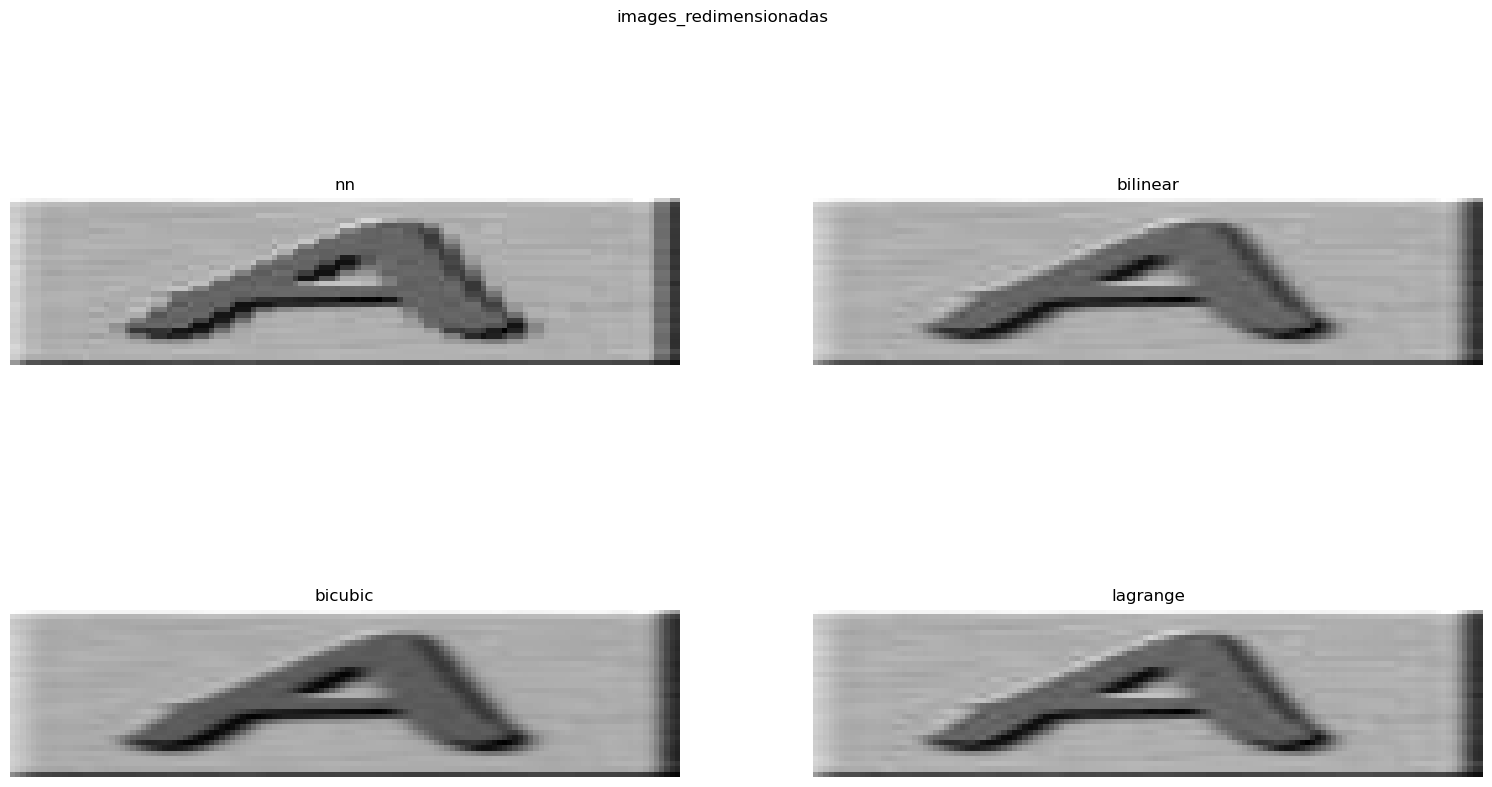

In [12]:
show_images(
    (2, 2),
    [scaled_nearest_neighbor, scaled_bilinear, scaled_bicubic, scaled_lagrange],
    ['nn', 'bilinear', 'bicubic', 'lagrange'],
    f'images_redimensionadas',
)

 **Idéia:**
 Para redimensionar a imagem, criamos uma imagem vazia com a nova dimensão, calculamos os indices de cada pixel na imagem original e mapeamos estes indices para suas posições na nova imagem redimensionada. O preenchimento dos pixels pode ser realizado a partir de um dos métodos escolhidos.

 **Implementação:**
 Após calcular os indices com a nova dimensão, dividimos x e y pela escala aplicada em cada eixo. Com estes, aplicamos a formula definida a partir do método escolhido para interpolação.
 
 **Chamada e parâmetros:**
 A função `scale_image` recebe a escala desejada ou nova dimensão da imagem,a imagem a redimensionar, e o método de interpolação, e retorna a imagem redimensionada.
 
 Cada método de interpolação recebe os novos indices da imagem redimensionada, e a imagem a redimensionar, retornando a imagem redimensionada.
 
 **Limitações:**
 Escolher uma escala para redimensionar a imagem nos dois eixos, ou a nova dimensão da imagem.
 
 **Resultados:**
  - Interpolação pelo Vizinho Mais Próximo (`nn`): Para cada pixel na imagem redimensionada, escolhemos para preenchimento o pixel mais próximo na imagem original. Esse método é bastante rápido, porem gera uma imagem bastante serrilhada.
 - Interpolação Bilinear (`bilinear`): Para cada pixel na imagem redimensionada, escolhemos para preenchimento através da média de vizinhança 4 do pixel mais próximo na imagem original. A imagem gerada possui uma distinção de pixels bem menor ao comparar com o `nn`
 - Interpolação Bicúbica (`bicubic`): Para cada pixel na imagem redimensionada, escolhemos para preenchimento através da média de vizinhança 4x4 do pixel mais próximo na imagem original. Para o calcula da interpolação dos 16 pixels utilizamos a função B-spline. A imagem gerada mais suavizada, e um pouco mais borrada que a gerada pela `bilinear`
 - Interpolação por Polinômios de Lagrange (`lagrange`): Similar a `bicubic`, consideramos a vizinhança 4x4, mas utilizamos a interpolação por polinômios de Lagrange para substituir o B-spline. Essa substituição mantem a suavização da `bilinear`, melhorando sua nitidez.

### Rotacionar

In [13]:
def translation_matrix(tx, ty):
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ], dtype=float)

def rotation_matrix(theta):
    theta = np.radians(theta)
    return np.array([
        [np.cos(theta), np.sin(theta), 0],
        [-np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ], dtype=float)

def transform_coords_matrix(indices):
    coords = indices.reshape(2, -1)
    return np.vstack((coords, np.ones_like(coords[1])))

In [14]:
def rotate_image(theta, image, interpolation_method):
    h, w = image.shape
    indices = np.indices((w, h))
    tx, ty = w // 2, h // 2

    T = translation_matrix(tx, ty)
    R = rotation_matrix(theta)

    A = T @ R @ np.linalg.inv(T)

    coords = transform_coords_matrix(indices)
    warp_coords = A @ coords

    x_, y_ = warp_coords[0, :], warp_coords[1, :]
    x_, y_ = x_.reshape((w, h)), y_.reshape((w, h))
    invalid_coords = np.logical_or(
        np.logical_or(x_ > w - 1, y_ > h - 1),
        np.logical_or(x_ < 0, y_ < 0)
    )
    x_ = np.clip(x_, 0, w - 1).round().astype(int)
    y_ = np.clip(y_, 0, h - 1).round().astype(int)

    indices[0] = x_
    indices[1] = y_
    rotated = interpolation_method(indices, image)
    rotated[invalid_coords] = 0

    return rotated

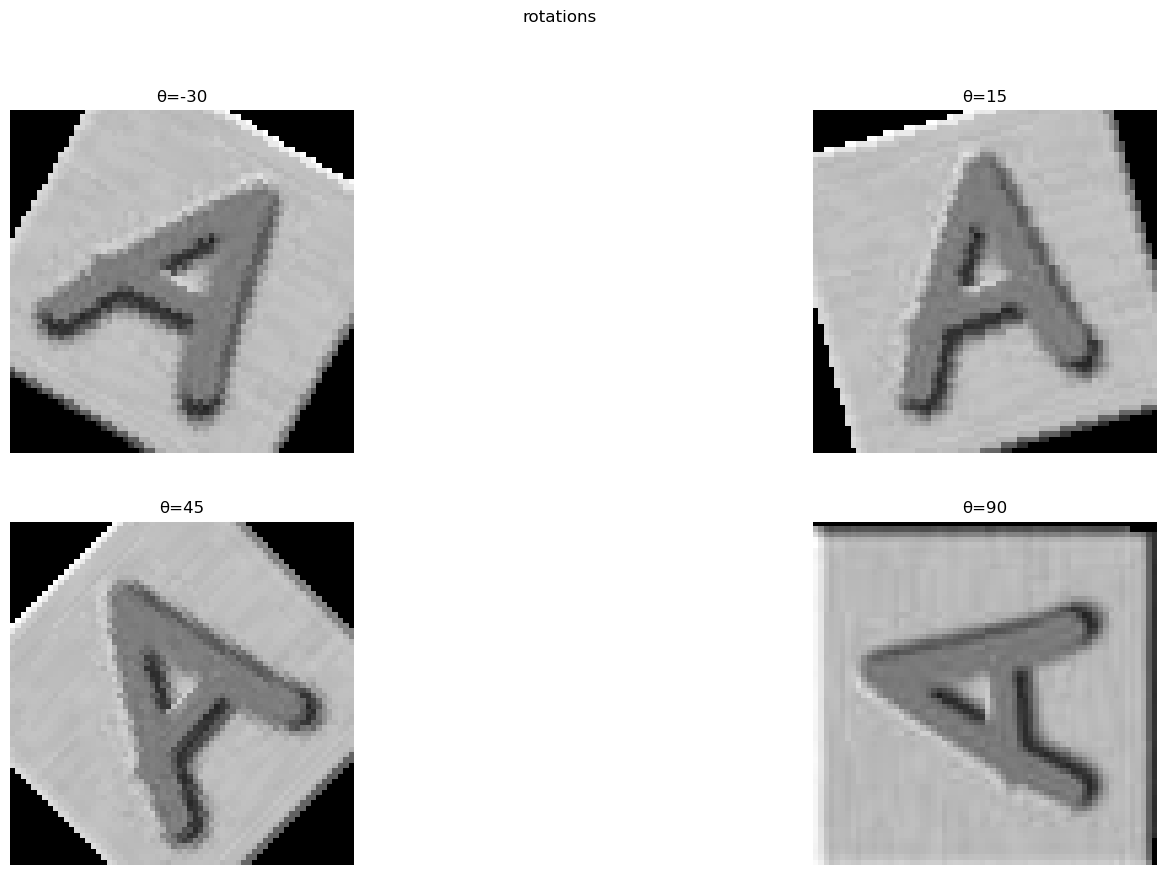

In [15]:
angles = (-30, 15, 45, 90)
show_images(
    (2, 2),
    [rotate_image(theta, image, bilinear_interpolation) for theta in (-30, 15, 45, 90)],
    [f'θ={theta}' for theta in (-30, 15, 45, 90)],
    'rotations'
)

 **Idéia:**
 Para rotacionar a imagem, transladamos o centro da imagem, aplicamos a matriz de rotação, transladamos o centro para o ponto original, e apos isso aplicamos o método de interpolação escolhido.

 **Implementação:**
 Após calcular o centro da imagem, ciamos a matriz de translação, e com o angulo escolhido criamos a matriz de rotação. Combinamos as matrizes de translação e rotação para criar a matriz de transformação da imagem, e aplicamos a matriz de transformação na matriz de coordenadas da imagem original. Com a matriz de coordenadas transformadas, calculamos os indices da imagem rotacionada, e aplicamos o metodo de interpolação para calcular o preenchimendo dos pixels.
 
 **Chamada e parâmetros:**
 A função `rotate_image` recebe o angulo de rotação, a imagem para rotacionar e o método de interpolação.
 
 As funções `rotation` e `translation` geram as matrizes de rotação e translação respectivamente.
 
 **Limitações:**
 
 
 **Resultados:**
 Os resultados produzidos foram esprados a partir dos angulos de rotação. O nível de rotação influencia a qualidade da imagem gerada devido ao método de interpolação.

## Colagem

In [16]:
image_A = image_from_url_or_disk('https://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
image_B = image_from_url_or_disk('https://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')

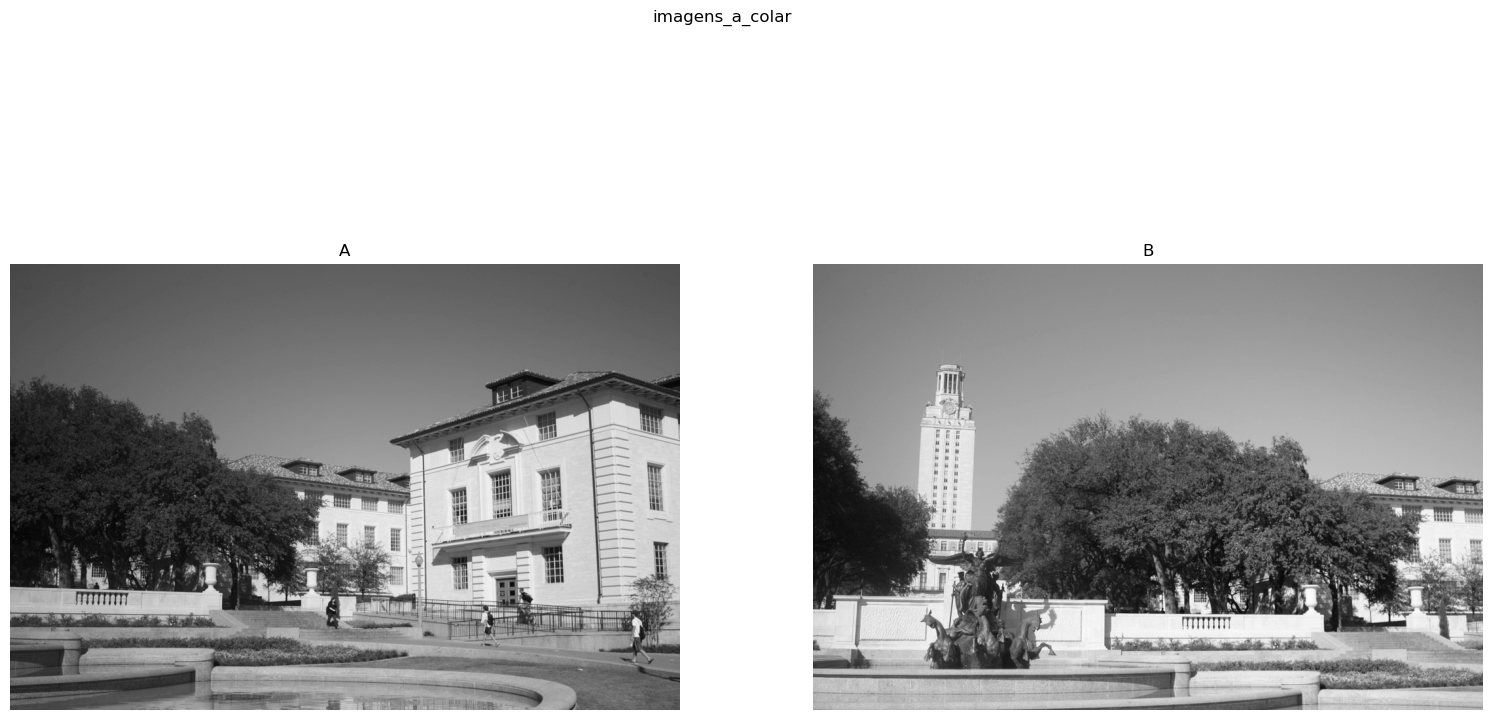

In [17]:
show_images((1, 2), [image_A, image_B], ['A', 'B'], 'imagens_a_colar')

In [18]:
class BRIEF_create:
    def __init__(self):
        # Initiate FAST detector
        self.star = cv2.xfeatures2d.StarDetector_create()
        # Initiate BRIEF extractor
        self.brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    def detectAndCompute(self, img, mask):
        # find the keypoints with STAR
        kp = self.star.detect(img, mask)
        # compute the descriptors with BRIEF
        kp, des = self.brief.compute(img, kp)
        return kp, des

In [19]:
def detect_keypoint_and_description(img, method='SIFT'):
    allowed_methods = {
        'SIFT': cv2.SIFT_create(),
        'SURF': cv2.xfeatures2d.SURF_create(),
        'BRIEF': BRIEF_create(),
        'ORB': cv2.ORB_create()
    }
    if method not in allowed_methods:
        raise ValueError(f'method must be one of {allowed_methods}')
    detector = allowed_methods[method]
    return detector.detectAndCompute(img, None)

In [20]:
key_points_A_sift, features_A_sift = detect_keypoint_and_description(image_A, 'SIFT')
key_points_B_sift, features_B_sift = detect_keypoint_and_description(image_B, 'SIFT')

key_points_A_surf, features_A_surf = detect_keypoint_and_description(image_A, 'SURF')
key_points_B_surf, features_B_surf = detect_keypoint_and_description(image_B, 'SURF')

key_points_A_brief, features_A_brief = detect_keypoint_and_description(image_A, 'BRIEF')
key_points_B_brief, features_B_brief = detect_keypoint_and_description(image_B, 'BRIEF')

key_points_A_orb, features_A_orb = detect_keypoint_and_description(image_A, 'ORB')
key_points_B_orb, features_B_orb = detect_keypoint_and_description(image_B, 'ORB')

In [21]:
def plot_features(img_a, kps_a, img_b, kps_b, method):
    plt.figure(figsize=(19, 10))
    for g, (i, k, n) in enumerate(zip([img_a, img_b], [kps_a, kps_b], ['A', 'B']), start=1):
        plt.subplot(1, 2, g)
        plt.imshow(cv2.drawKeypoints(i, k, None, color=(0,255,0)))
        plt.axis('off')
        plt.title(n)
    plt.suptitle(method)
    plt.show()

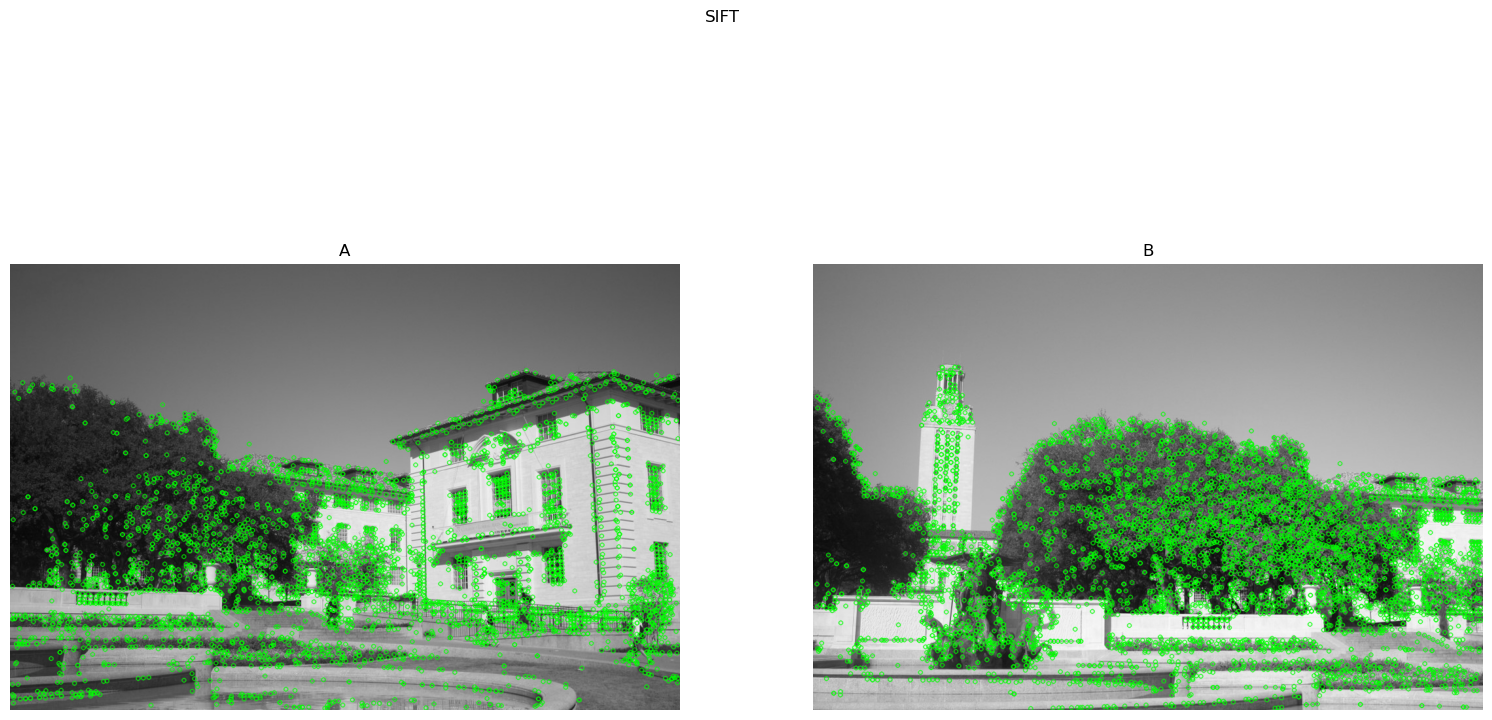

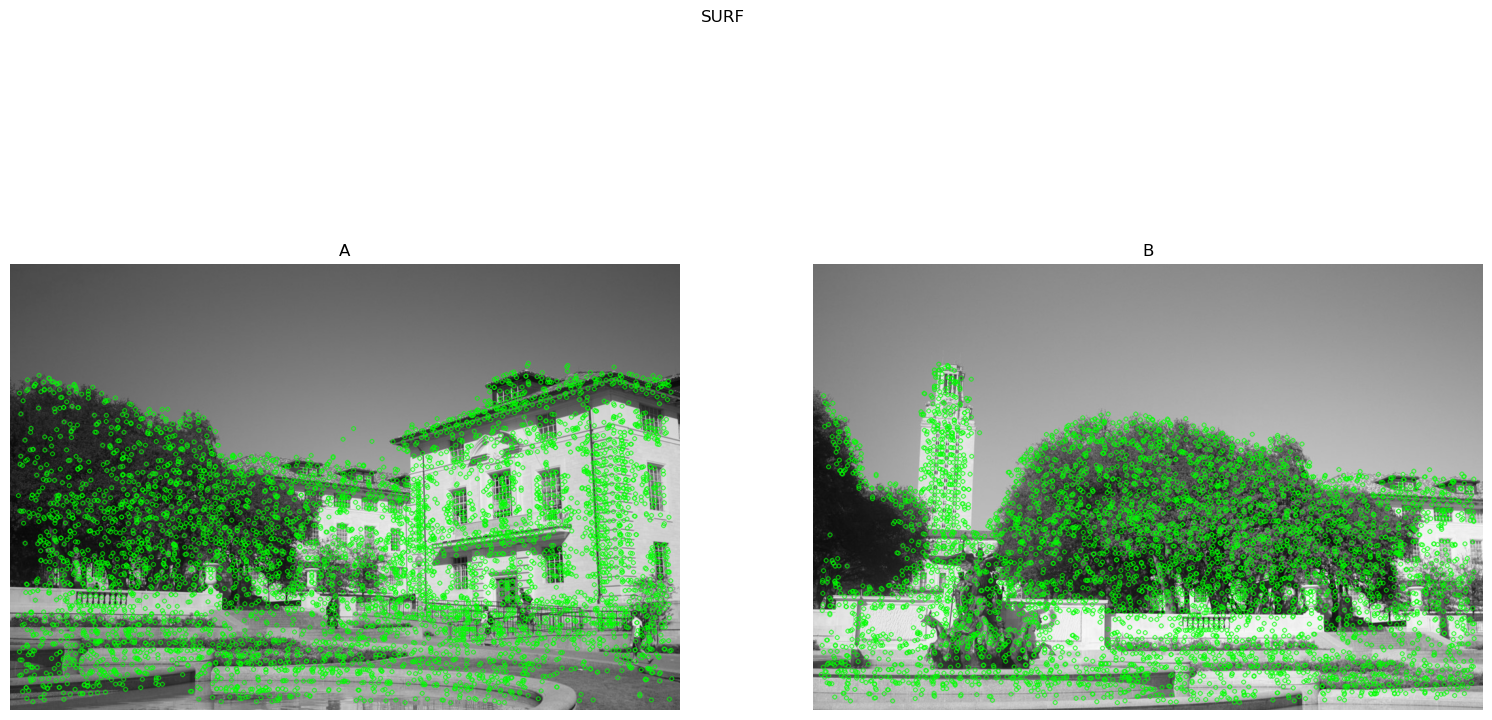

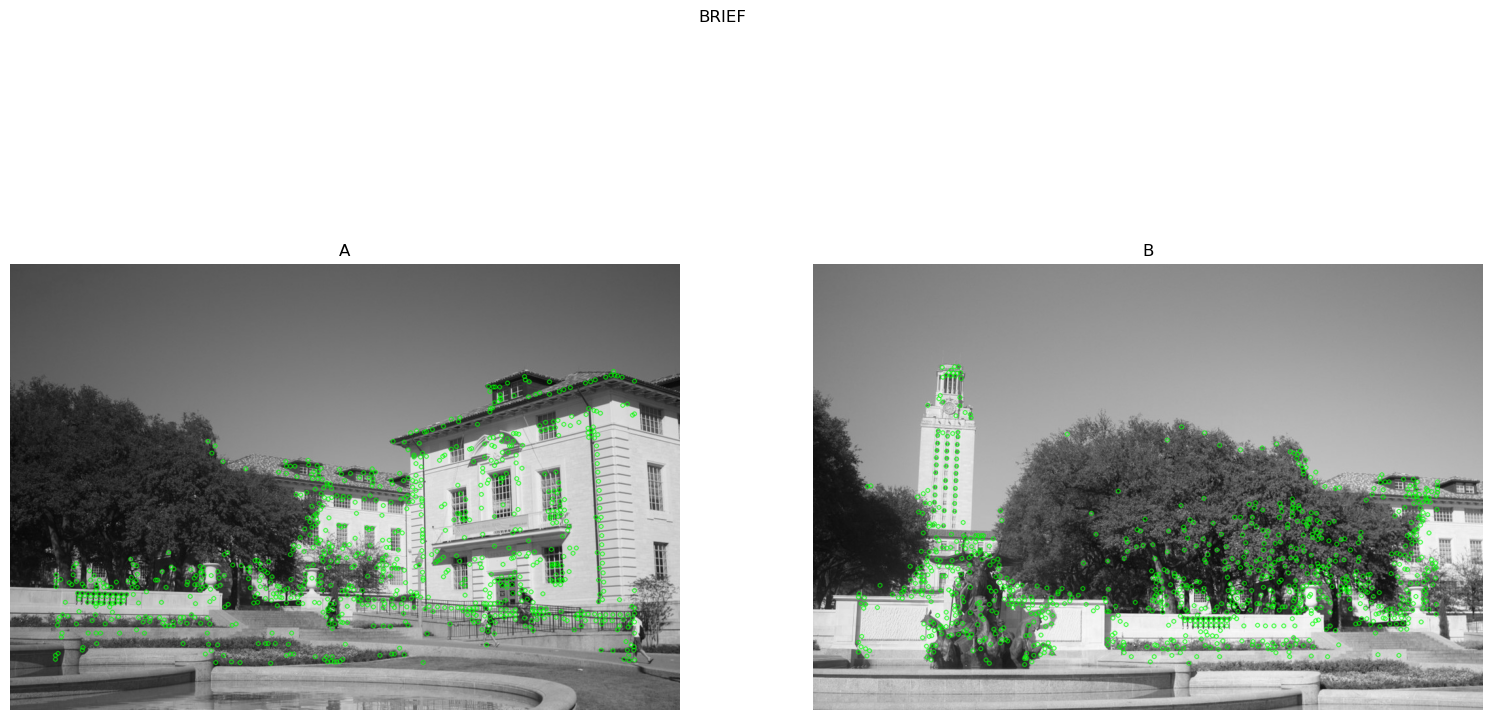

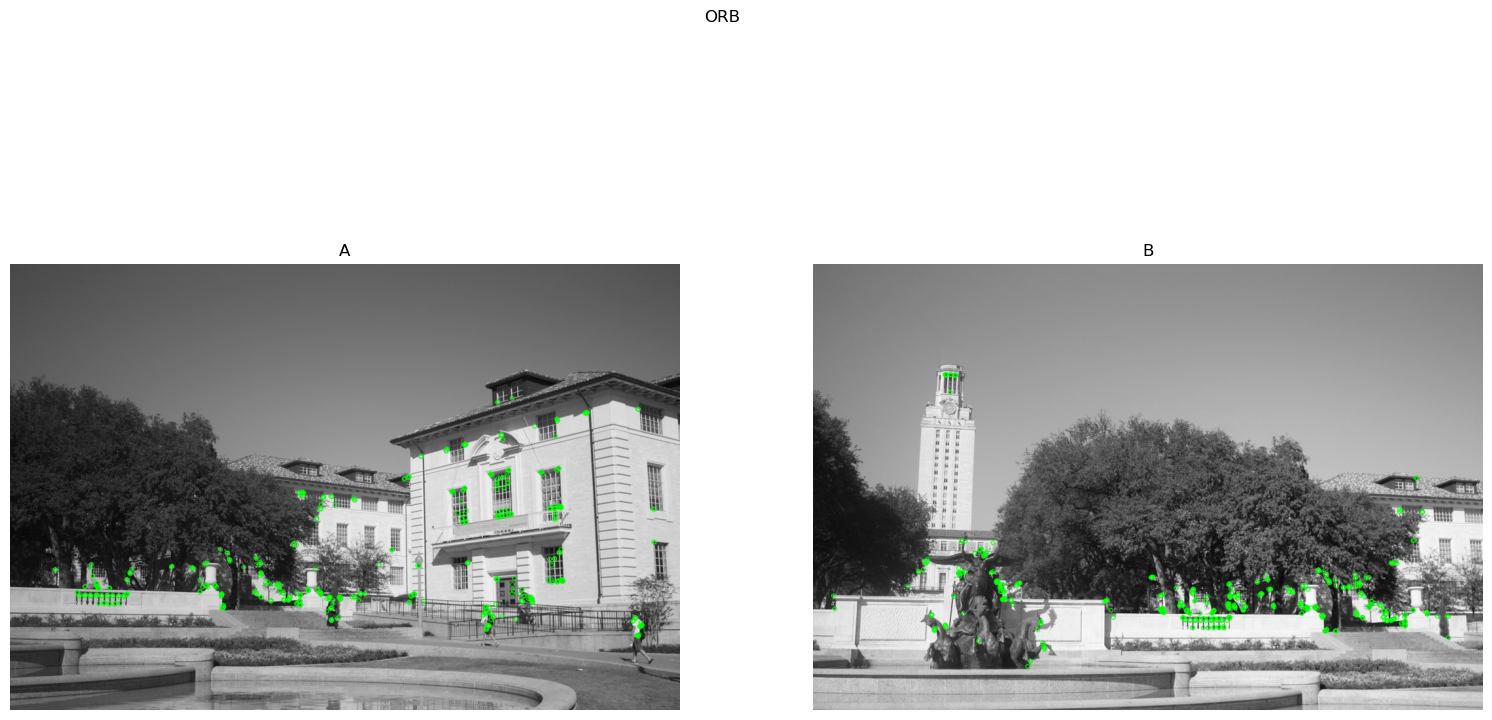

In [22]:
plot_features(image_A, key_points_A_sift, image_B, key_points_B_sift, 'SIFT')
plot_features(image_A, key_points_A_surf, image_B, key_points_B_surf, 'SURF')
plot_features(image_A, key_points_A_brief, image_B, key_points_B_brief, 'BRIEF')
plot_features(image_A, key_points_A_orb, image_B, key_points_B_orb, 'ORB')

In [23]:
def match_correspondences(feat_a, feat_b):
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    best_matches = matcher.match(feat_a, feat_b)
    return sorted(best_matches, key = lambda x: x.distance)

In [24]:
best_matches_sift = match_correspondences(features_A_sift, features_B_sift)
best_matches_surf = match_correspondences(features_A_surf, features_B_surf)
best_matches_brief = match_correspondences(features_A_brief, features_B_brief)
best_matches_orb = match_correspondences(features_A_orb, features_B_orb)

In [25]:
def plot_correspondences(matches, img_a, kps_a, img_b, kps_b, method, n_points=100):
    plt.figure(figsize=(20,8))

    img = cv2.drawMatches(
        img_a, kps_a, img_b, kps_b, matches[:n_points],
        None,
        matchColor=(0,255,0), singlePointColor=(0, 0, 255),
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.imshow(img)
    plt.axis('off')
    plt.title(method)
    plt.show()

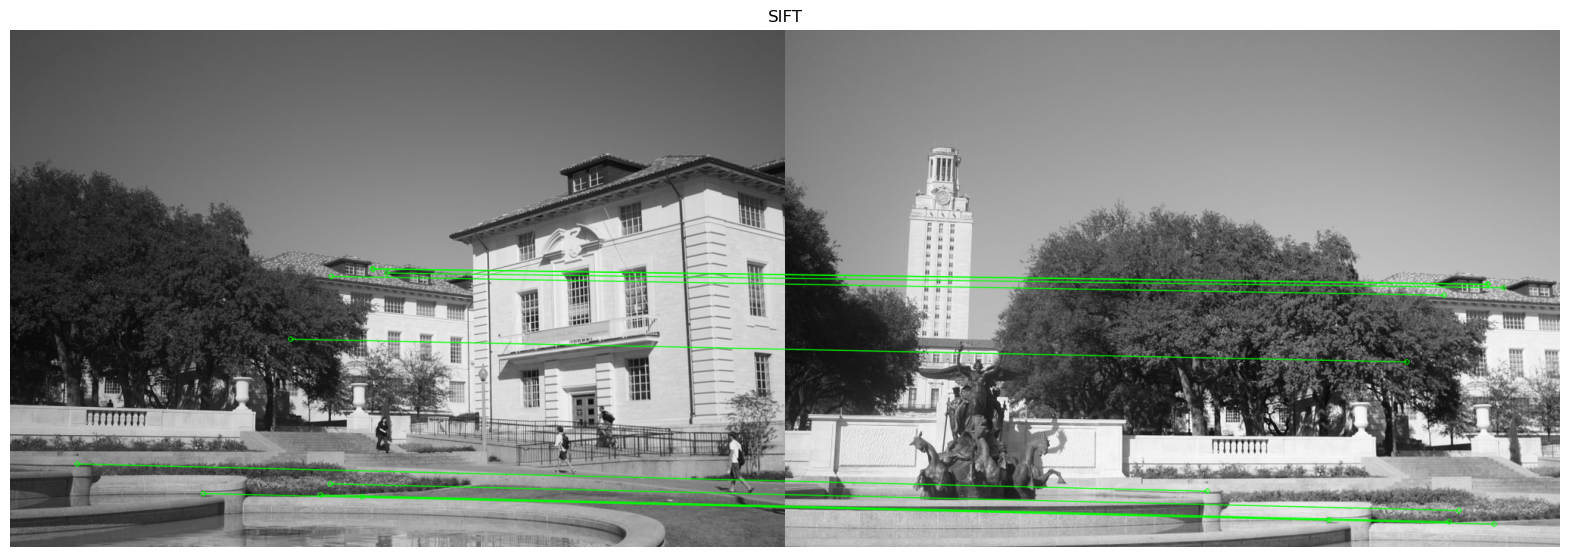

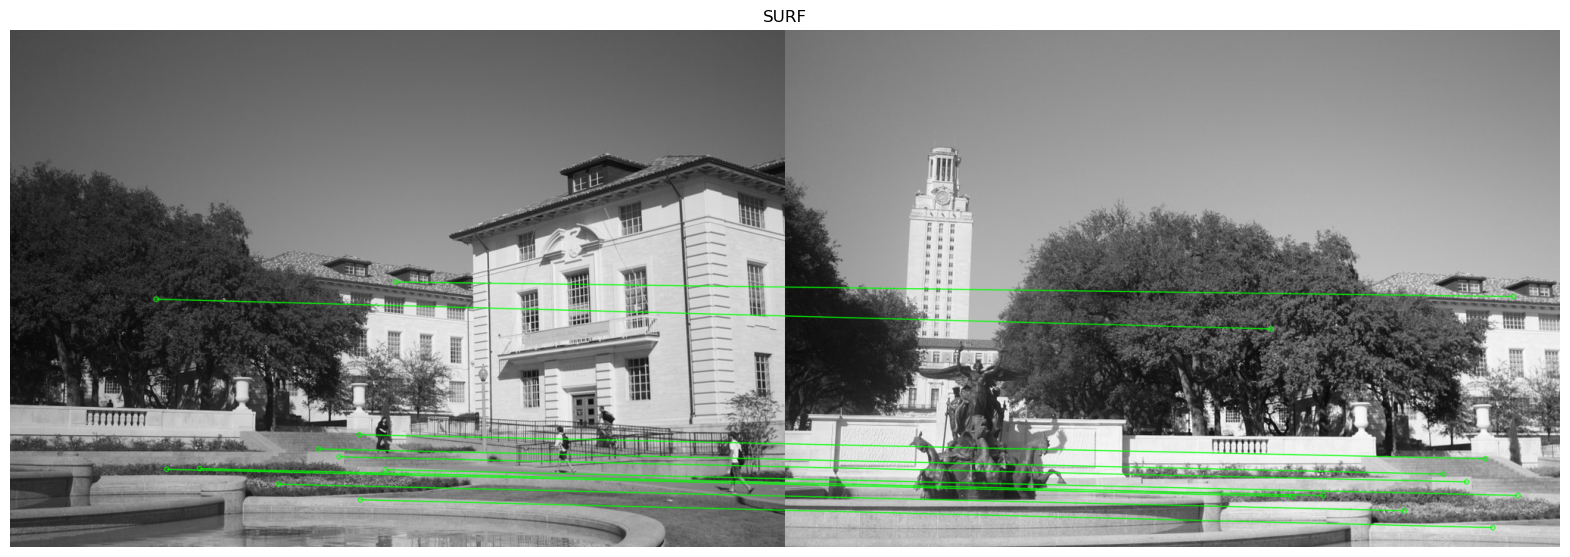

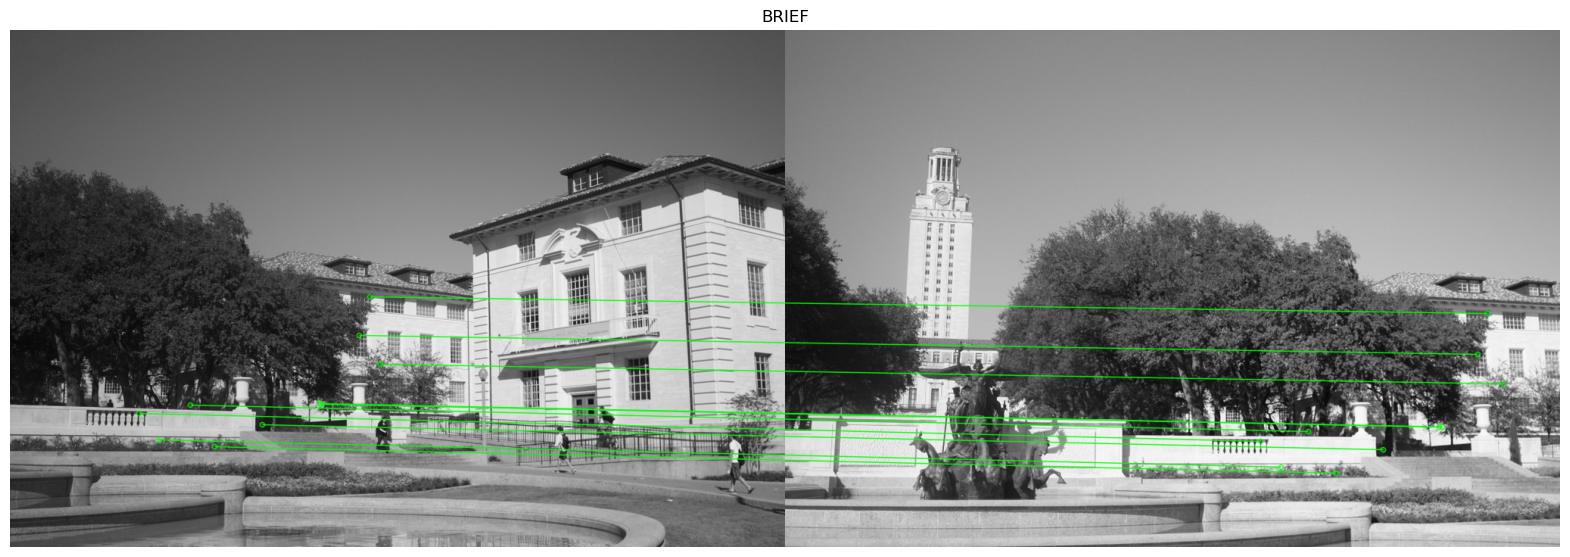

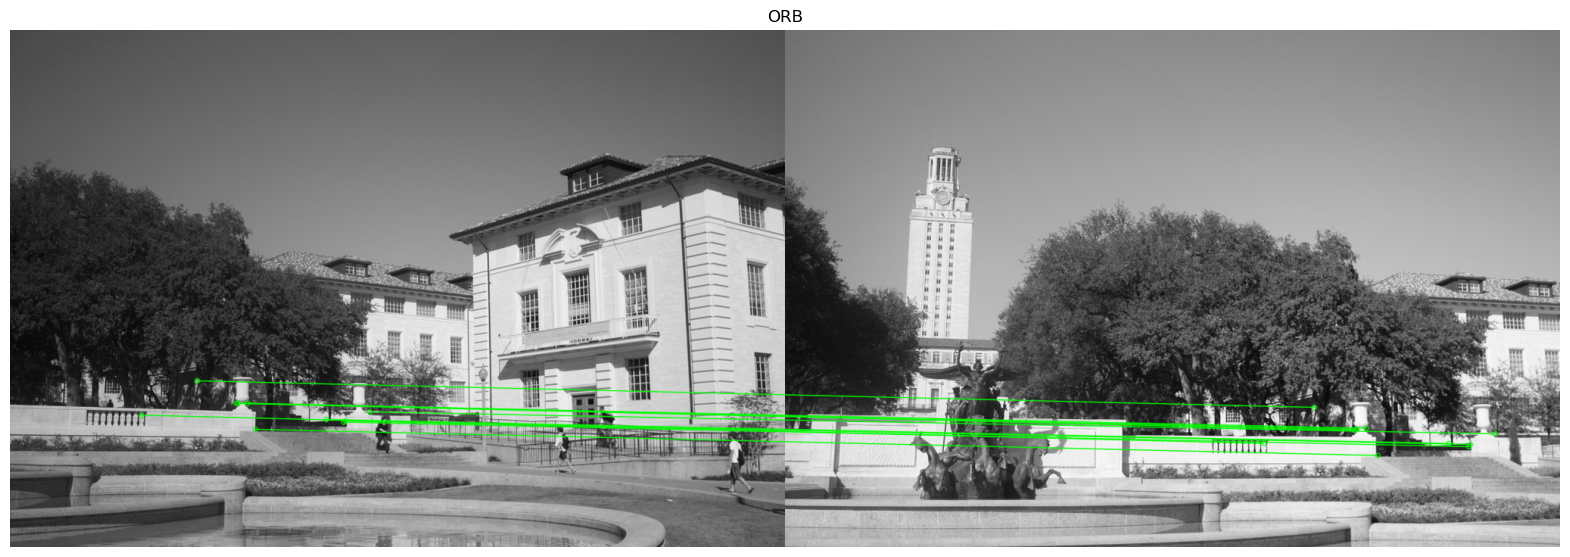

In [26]:
n_points = 10
plot_correspondences(best_matches_sift, image_A, key_points_A_sift, image_B, key_points_B_sift, 'SIFT', n_points=n_points)
plot_correspondences(best_matches_surf, image_A, key_points_A_surf, image_B, key_points_B_surf, 'SURF', n_points=n_points)
plot_correspondences(best_matches_brief, image_A, key_points_A_brief, image_B, key_points_B_brief, 'BRIEF', n_points=n_points)
plot_correspondences(best_matches_orb, image_A, key_points_A_orb, image_B, key_points_B_orb, 'ORB', n_points=n_points)

In [27]:
def homography_matrix(kps_a, kps_b, matches):
    kps_a = np.float32([kp.pt for kp in kps_a])
    kps_b = np.float32([kp.pt for kp in kps_b])

    matches_a = [match.queryIdx for match in matches]
    matches_b = [match.trainIdx for match in matches]

    points_a = kps_a[matches_a]
    points_b = kps_b[matches_b]

    H, _ = cv2.findHomography(points_a, points_b, cv2.RANSAC, 5)
    return H

In [28]:
H = homography_matrix(key_points_A_orb, key_points_B_orb, best_matches_orb)

In [29]:
print('Matriz de Homografia')
H

Matriz de Homografia


array([[ 8.21636220e-01,  1.14725765e-01,  4.25697782e+02],
       [-1.29533923e-01,  1.00027362e+00,  5.46604962e+01],
       [-1.99582690e-04,  5.22589237e-05,  1.00000000e+00]])

In [30]:
def crop_empty_spaces(img):
    coords = cv2.findNonZero(img)
    x, y, w, h = cv2.boundingRect(coords)
    return img[y:y+h, x:x+w]

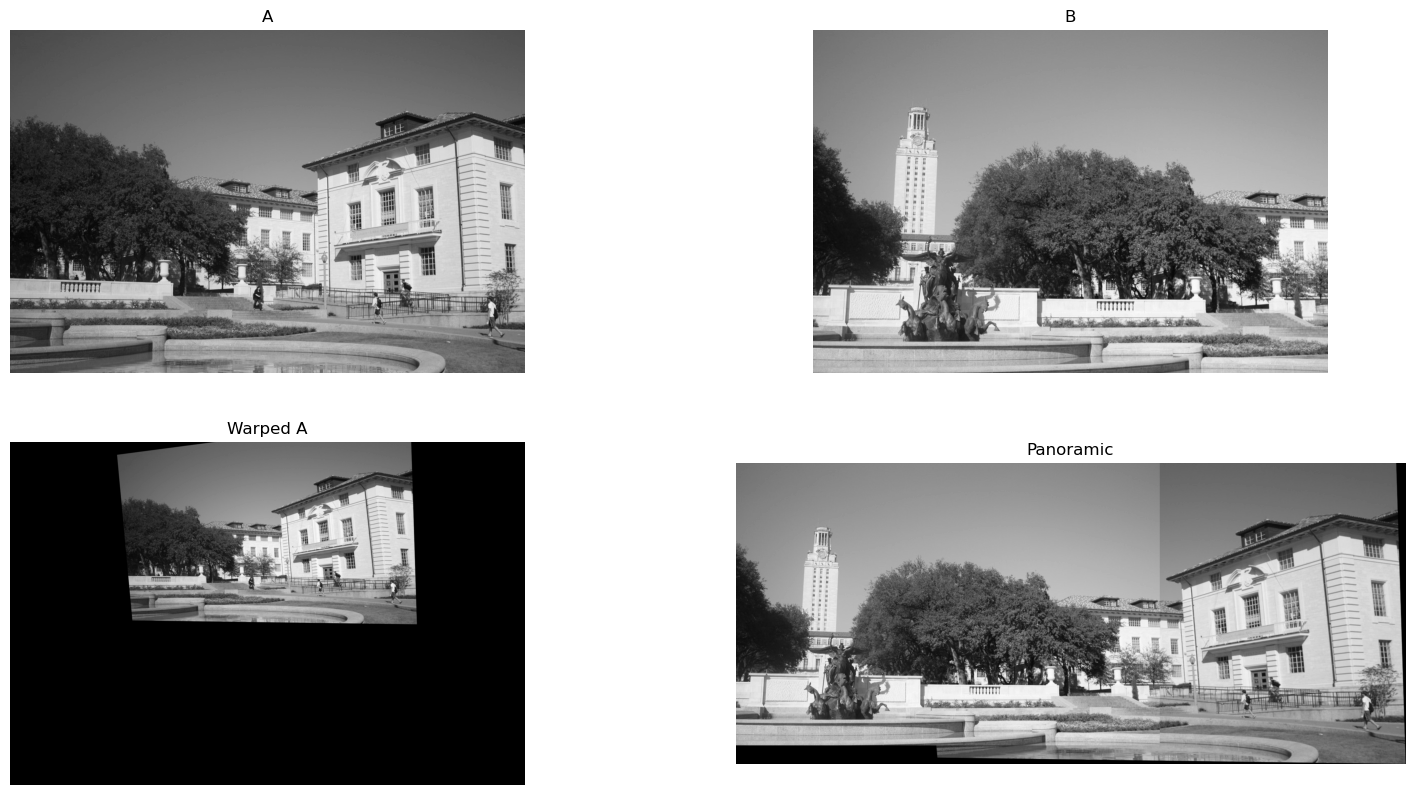

In [31]:
img_a, img_b = image_A, image_B

h, w = np.array(image_A.shape) + np.array(image_B.shape)

panoramic = cv2.warpPerspective(img_a, H, (w, h))
panoramic_b = panoramic.copy()
panoramic_b[0:img_b.shape[0], 0:img_b.shape[1]] = img_b

show_images((2, 2), [image_A, image_B, panoramic, crop_empty_spaces(panoramic_b)], ['A', 'B', 'Warped A', 'Panoramic'])

 **Idéia:**
 Com duas imagens, detectar em cada uma seus pontos de interesse, e mapear estes pontos as suas localizações na outra imagem. Com os pontos de interesse localizados e relacionados, a matriz de homografia permite transformar uma imagem a fim de preencher com a outra e montar uma imagem panorâmica.
  
 **Implementação:**
 Detectar os pontos de interesse e descritores de cada imagem utilizando um dos métodos escolhidos. A partir destas caracteristicas, relacionar os pontos de interesse da imagem A aos pontos de interesse na imagem B, encontrando assim as correspondencias das duas imagems. Com estas correspondencias, calculamos a matriz de homografia. Criando uma nova imagem vazia para receber as imagens A e B, transformamos a imagem A, posicionamos na vazia, e preenchemos esta com a imagem.
 
 **Chamada e parâmetros:**
A função `detect_keypoint_and_description` recebe a imagem e o método de detecção de pontos de interesse selecionados, retornando seus pontos de interesse e descritores.

A função `match_correspondences` recebe os descritores das imagens, retornando as correspondencias entre as duas imagens.

A função `homography_matrix` recebe os pontos de interesse das imagens e as correspondencias.
 
**Resultados:**
Observando as imagens geradas pela detecção de pontos de interesse, vemos que os algoritmos `SIFT` e `SURF` possuem resultados bastante semelhantes, o que é esperado já que o `SURF` é uma adaptação mais robusta e rápida do `SIFT`. Ambos detectam pontos em toda a imagem.

O `BRIEF` apresenta um comportamento diferente, redizindo a quantidade de pontos encontrados ao focar apenas nas partes de mais detalhes da imagem, no caso sendo as contruções. O `ORB` segue os passos do `BRIEF`, tambem esperado por ser uma adaptação deste, focando ainda mais nos detalhes mais caracteristicos de cada imagem, reduzindo ainda mais a quantidade de pontos de interesse.

As visualizações entre os pontos correspondentes no par de imagens permite observar os 10 mais relevantes entre elas, e como estão posicionados em cada uma.

Por fim, vemos como a matriz de homografia é capaz de transformar a perspectiva da imagem para acomodar seu par.